# 2D Jet SPOD

In this tutorial we will explore a small dataset provided with this package that contains pressure data of the flow exiting a nozzle (also referred to as a jet).
Cylindrical coordinates (r,x) are used and they are equally spaced. 
In particular, starting from a database of pre computed solutions, we want to:
- extract the SPOD (coherent in space and time) modes
- compute the coefficients projecting the data on the SPOD basis built by gathering the modes
- learn the latent dynamics through a LSTM-based neural network
- predict future coefficients, i.e. the future evolution in time of the flow field
- compare predictions with the actual flow realizations

In detail, the starting dataset consists of 1000 flow realizations which represent the pressure field at different time instant. The time step is 12 hours.

## Loading libraries and data

The dataset is part of the data used for the regression tests that come with this library and is stored into `tests/data/fluidmechanic_data.mat`. The first step to anlyze this dataset is to import the required libraries, including the custom libraries
- 'from pyspod.spod_low_storage import SPOD_low_storage'
- 'from pyspod.spod_low_ram     import SPOD_low_ram'
- 'from pyspod.spod_streaming   import SPOD_streaming'
- 'from pyspod.emulation   import Emulation'
- 'import pyspod.utils_weights as utils_weights'
- 'import pyspod.utils as utils'.  

The first three contain different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.



In [2]:
# python libraries
import os
import sys
import h5py
import shutil
import numpy as np

from pathlib import Path

# Current, parent and file paths import sys
CWD = os.getcwd()
sys.path.insert(0, os.path.join(CWD, "../../../../"))

# Import specific libraries
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
from pyspod.emulation   import Emulation
import pyspod.utils_weights as utils_weights
import pyspod.utils as utils  


The second step conists into importing data from "fluidmechanics_data.mat" located in the folder pysod/test/data and store them in a dictionary. 

In [3]:
file = os.path.join(CWD,'../../../../tests/data','fluidmechanics_data.mat')
variables = ['p']
with h5py.File(file, 'r') as f:
	data_arrays = dict()
	for k, v in f.items():
		data_arrays[k] = np.array(v)

## Define global variables and global parameters

The data are stored in a matrix `X` and, to be suitable to the `PySPOD` library, it must have the following features:
- first dimension must correspond to the number of time snapshots (1000 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (20, and 88 in our case, that correspond to radial and axial spatial coordinates).
We note that in the present test case the data matrix `X` used is already in a shape that is suitable to `PySPOD`, as its dimension is:
$$\text{$X$ dimensions} = 1000 \times 20 \times 88 $$


It is important to note at this point that we loaded all the required data into RAM, and stored it into a `numpy.ndarray`. We will later pass this array to the constructor of the `PySPOD` class for running our analysis. However, we could have used a different approach to load the data. In fact, the constructor to the `PySPOD` class accepts an argument called `data_handler`, that points to a function whose objective is to read the data at run time. This is particularly useful for large datasets, where it might be not possible to load all the data in RAM upfront. Therefore, in this case, we could simply define a data reader function as the following:

```
def read_data(data, t_0, t_end, variables): 
    ... implement here your method
    data: path to the data file
    t_0: start time slicing
    t_end: end time slicing
    variables: list with names of the variables

    return X
```

and pass it to the `PySPOD` constructor under the argument `data_handler`. The path to the data file, will then be specified in place of the data, under the argument `X`. See below, when we setup the analysis and call the constructor for a more detailed explantion of the parameters `X` and `data_handler`. In summary, if `X` is a numpy.ndarray containing your data, `data_handler` is set to `False`, if `X` is a `str` containing the path to your data file, `data_handler` is a function that reads your data, and whose arguments must be: (1.) `str` containing the path to the data file, (2) `int` containing the start time snapshot for slicing the data sequentially at run time, (3) `int` containing the end time snapshot for slicing the data sequentially at run time, and (4) a `list` containing the name of the variables in your data file. 



The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `block_dimension`: number of snapshots in each block, it is related to the maximum number of frequency one can extract: n_freq=n_block/{2}+1
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_DFT`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data

**Note that we do not set any parameter for the Weights adopted to compute th einner product in the SPOD calculation. In this case, the algorithm will use automatically uniform weighting (weighting equal 1), and it will prompt a warning stating the use of default uniform weighting.** 

In the dictionary 'params_emulation' the following variables, which allow to define some relevant parameters of a single layer neural network, are stored:
- `network`: string, type of neural network. In the present tutorial 'lstm'
- `epochs`: integer, number of epochs
- `batch_size`: integer, batch size
- `n_seq_in`: integer, dimension of input sequence 
- `n_seq_out`: integer, number of steps to predict
- `n_neurons`: number of neurons in each layer
- `dropout`: value of the dropout
- `savedir`: string, name of the directory where results will be saved

In the present test case we use 60 (`n_seq_in`=60) previous values of the coefficients in order to evaluate the next one (`n_seq_out`=1).

In [4]:
dt = data_arrays['dt'][0,0]
block_dimension = 64 * dt
X = data_arrays[variables[0]].T
t = dt * np.arange(0,X.shape[0]); t = t.T
nt = t.shape[0]
x1 = data_arrays['r'].T; x1 = x1[:,0]
x2 = data_arrays['x'].T; x2 = x2[0,:]


trainingDataRatio = 0.8 # ratio between training data number and total number of snapshots
testingDataRatio = (1-trainingDataRatio)

# parameters
params = dict()

# -- required parameters
params['time_step'   	   ] = dt 						# data time-sampling
params['n_space_dims'    ] = 2							# number of spatial dimensions (longitude and latitude)
params['n_variables'     ] = 1							# number of variables
params['n_DFT'           ] = np.ceil(block_dimension / dt) # length of FFT blocks
# -- optional parameters
params['overlap'          ] = 50					# dimension in percentage (1 to 100) of block overlap
params['mean_type'        ] = 'blockwise' # type of mean to subtract to the data
params['normalize_weights'] = False	 			# normalization of weights by data variance
params['normalize_data'   ] = False  			# normalize data by data variance
params['n_modes_save'     ] = 8  		# modes to be saved
params['conf_level'       ] = 0.95   			# calculate confidence level
params['savedir'          ] = os.path.join(CWD, 'results', Path(file).stem)
params['reuse_blocks'] = False

params_emulation = dict()

params_emulation['network'     ] = 'lstm' 						# type of network
params_emulation['epochs'      ] = 130 						# number of epochs
params_emulation['batch_size'  ] = 32							# batch size
params_emulation['n_seq_in'    ] = 60							# dimension of input sequence 
params_emulation['n_seq_out'   ] = 1                          # number of steps to predict
params_emulation['n_neurons'   ] = 25                          # number of neurons
params_emulation['dropout'   ] = 0.15                          # dropout
params_emulation['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem)


## Compute SPOD modes and coefficients 

The following lines of code are used for the initialization of variables. `X_train` and `X_test` are numpy data structures which contain the training set and the testing set respectively; therefore their dimensions are (`nt_train`, 20, 88) and (`nt_test`, 20, 88), being in this test case `nt_train`= $0.8\cdot nt$ and nt_test=$0.2\cdot nt$. 

In [5]:
#  training and testing database definition
nt_train = int(trainingDataRatio * nt)
X_train = X[:nt_train,:,:]
nt_test = nt - nt_train
X_test  = X[nt_train:,:,:]


After we have initialized the variables above, we are ready to perform the SPOD analysisl at the end of this pahse we will have the SPOD modes computed for different ranges of frequencies.
This phase can be computationally expansive and different techniques have been developed in order to handle data.
If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

The arguments to the constructor are defined as follows:
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See our data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 
  
 The `fit()` method returns a `PySPOD` object containg the results, the input arguments are a numpy array `X_train` and its first dimension (`nt`)

In [6]:
# SPOD analysis
SPOD_analysis = SPOD_low_storage(
	params=params, 
	data_handler=False, 
	variables=variables
	)

# fit 
spod = SPOD_analysis.fit(X_train, nt=nt_train)

 
Initialize data
------------------------------------

SPOD parameters
------------------------------------
Problem size               :  0.010490417480468766 GB. (double)
No. of snapshots per block :  64
Block overlap              :  32
No. of blocks              :  24
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  uniform
Mean                       :  blockwise
Number of frequencies      :  33
Time-step                  :  0.2
Time snapshots             :  800
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  8
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_SPOD/results/fluidmechanics_data
Save FFT blocks            :  False
Reuse FFT blocks           :  False
Spectrum type             :  one-sided (real-valued signal)
------------------------------------

------

/Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_SPOD/../../../../pyspod/spod_base.py:116: UserWarning: Parameter `weights` not equal to an `numpy.ndarray`.Using default uniform weighting
  warnings.warn(


block 10/24 (288:352)
block 11/24 (320:384)
block 12/24 (352:416)
block 13/24 (384:448)
block 14/24 (416:480)
block 15/24 (448:512)
block 16/24 (480:544)
block 17/24 (512:576)
block 18/24 (544:608)
block 19/24 (576:640)
block 20/24 (608:672)
block 21/24 (640:704)
block 22/24 (672:736)
block 23/24 (704:768)
block 24/24 (736:800)
--------------------------------------
 
Calculating SPOD (low_storage)
--------------------------------------


computing frequencies: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 291.20it/s]

--------------------------------------
 
Results saved in folder  /Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_SPOD/results/fluidmechanics_data/nfft64_novlp32_nblks24
Elapsed time:  0.6110460758209229 s.


In the transform function the pressure fluctuations are computed by subtracting the mean field from the snapshots. Then the SPOD modes are ordered by frequency and the coefficients are obtained by projecting the snapshots representing the pressure fluctuations onto the reduced POD basis obtained by gathering the most significant modes. In details, the `spod.transform` function accept as input
- data: dataset on which the analysis is performed
- nt: number of snapshots of the dataset 'data'

and it returns a dictionary which contains the following keywords:
- time_mean: the average in time of snapshots
- phi_tilde: the first most significant modes ordered by frequency. These modes identify a reduced basis, significant for the case at hand.
- coeffs: the coefficients obtained by projecting the snapshots onto the SPOD basis
- reconstructed_data: snapshots reconstructed by superimposing the modes multiplied by the coefficients

The same function is used for the testing set; the testing coefficients are obtaied by projecting the pressure fluctuations snapshots of`X_test` onto the SPOD basis previously computed.

In [7]:
# transform
coeffs_train = spod.transform(X_train, nt=nt_train, T_lb=None, T_ub=None)
coeffs_test  = spod.transform(X_test , nt=nt_test, T_lb=None, T_ub=None)

coeffs.shape =  (264, 800)
coeffs.shape =  (264, 200)


## Learning the latent space dynamics

The following lines are required in order to initialize the data structures needed to train the neural network and to store its output 

In [8]:
# initialization of variables and structures
n_modes = params['n_modes_save'] 
n_freq = spod._n_freq_r
n_feature = coeffs_train['coeffs'].shape[0]

data_train = np.zeros([n_freq,coeffs_train['coeffs'].shape[1]],dtype='complex')
data_test = np.zeros([n_freq,coeffs_test['coeffs'].shape[1]],dtype='complex')
coeffs_emul = np.zeros([coeffs_test['coeffs'].shape[0],coeffs_test['coeffs'].shape[1]],dtype='complex')
coeffs_tmp = np.zeros([n_freq,coeffs_test['coeffs'].shape[1]],dtype='complex')


The coefficients previously evaluated can now be used for training a LSTM-based neural network.
The Emulation constructor requires the following parameters:
- params_emulation: dict containing the parameters described in the previous sections. They contain all the relevant data for creating a single-layer neural network with Dropout

The neural network is initialized by calling `spod_emulation.model_initialize` that requires the data set which the network will be trained with.

In [9]:
# LSTM
spod_emulation = Emulation(params_emulation)

# initialization of the network
spod_emulation.model_initialize(data=data_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                5900      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 33)                858       
Total params: 6,758
Trainable params: 6,758
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In this test case, we train `n_modes` separate neural networks, each of them contains `n_freq` features. Each network is associated to a different `idx` number.

### Scale data
It is a common practice to provide scaled input to the neural network. For this reason a scaler vector is computed by calling the function `compute_normalizationVectorReal`. Three different arguments can be used for defining the `normalizeMethod` variable:
- localmax: each coefficient is scaled by its local maximum
- globalmax: all the coefficients are scaled by the same value which represent the global maximum
- None: no scaling is applied. The output vector contains ones.
Once that the scaling vector is known, the scaling is applied both to the training dataset and to the testing one.

### Train the network
The training of the neural network is carried out by calling the `model_train` function. The following inputs are requested:
- `idx`: integer, it is an identifier associated to the neural network. Thanks to this idx, more than one network can be trained in the same run and the weights can be stored in different files.
- `data_train`: dataset used for the training
- `data_valid`: dataset used for the validation
- `plotHistory` (otpional): boolean, plot  the trainig history when set to `True`

The resulting weights are saved on files.
**If this function is commented and if a file with weights of a previously trained network with the same parameters and dimensions is present, the network is loaded automatically from file.**

### Predict
After that the neural network has been trained, predictions of the coefficients can be extracted with the aid of the `spod_emulation.model_inference` routine. This receives as inputs:
- `idx`: integer, a value which identify a previously trained neural network (in this case 0, since we have only one neural network)
- `data_input`: data which are used to start the prediction. This array can have an arbitary length. The first `n_seq_in` data are copied in the output vector and used for predicting the next `n_seq_out` steps

The output consists in a vector which has the same dimensions of data_input and contains the predicted scaled coefficients.

### Rescale data

The predicted coefficients are then scaled back by calling `utils.denormalize_data`.

In [11]:
for idx in range(n_modes):
	idx_x = list(range(idx, n_feature, n_modes))
    
	# scale data
	scaler  = \
		utils.compute_normalizationVector(coeffs_train['coeffs'][idx_x,:],normalizeMethod='localmax')
	data_train[:,:] = \
		utils.normalize_data(coeffs_train['coeffs'][idx_x,:], normalizationVec=scaler)
	data_test[:,:]  = \
		utils.normalize_data(coeffs_test['coeffs'][idx_x,:], normalizationVec=scaler)

    # train the network
	spod_emulation.model_train(idx,
		data_train=data_train, 
		data_valid=data_test,
		plotHistory=False
	)
    
	#predict 
	coeffs_tmp = spod_emulation.model_inference(
		idx,
		data_input=data_test
	)

	# rescale data
	coeffs_emul[idx_x,:] = utils.denormalize_data(coeffs_tmp, scaler)

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 60362.04it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 22749.77it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 4.5493e-04 - coeff_determination: -0.0445

24/24 [==============================] - 0s 14ms/step - loss: 4.2792e-04 - coeff_determination: -0.0983 - val_loss: 3.8288e-04 - val_coeff_determination: -0.9512
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 3.7927e-04 - coeff_determination: 0.0286 - val_loss: 3.5356e-04 - val_coeff_determination: -0.6628
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.4605e-04 - coeff_determination: 0.0605 - val_loss: 3.3421e-04 - val_coeff_determination: -0.4564
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.2321e-04 - coeff_determination: 0.0998 - val_loss: 3.2003e-04 - val_coeff_determination: -0.3494
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0773e-04 - coeff_determination: -0.8464 - val_loss: 3.0883e-04 - val_coeff_determination: -0.2521
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9617e-04 - coeff_determination: 0.2970 - val_loss: 2.9941e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 2.0108e-04 - coeff_determination: -0.8478 - val_loss: 1.8465e-04 - val_coeff_determination: 0.4171
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 1.9721e-04 - coeff_determination: 0.6573 - val_loss: 1.8541e-04 - val_coeff_determination: 0.4152
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0076e-04 - coeff_determination: -0.8240 - val_loss: 1.8283e-04 - val_coeff_determination: 0.4234
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0457e-04 - coeff_determination: 0.6718 - val_loss: 1.8242e-04 - val_coeff_determination: 0.4368
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0341e-04 - coeff_determination: 0.6542 - val_loss: 1.8186e-04 - val_coeff_determination: 0.4327
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0138e-04 - coeff_determination: 0.5905 - val_loss: 1.8244e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 1.9641e-04 - coeff_determination: 0.6688 - val_loss: 1.7145e-04 - val_coeff_determination: 0.4762
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 1.9471e-04 - coeff_determination: 0.5793 - val_loss: 1.7137e-04 - val_coeff_determination: 0.4699
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 1.9314e-04 - coeff_determination: 0.6814 - val_loss: 1.7070e-04 - val_coeff_determination: 0.4778
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 1.9554e-04 - coeff_determination: 0.6796 - val_loss: 1.7062e-04 - val_coeff_determination: 0.4879
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 1.9371e-04 - coeff_determination: 0.6747 - val_loss: 1.6953e-04 - val_coeff_determination: 0.4789
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0011e-04 - coeff_determination: 0.6510 - val_loss: 1.7046e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 62178.35it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 22539.56it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 2.4510e-04 - coeff_determination: 0.5956

24/24 [==============================] - 0s 15ms/step - loss: 2.3805e-04 - coeff_determination: 0.5849 - val_loss: 1.9022e-04 - val_coeff_determination: 0.4517
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2033e-04 - coeff_determination: 0.2108 - val_loss: 1.8549e-04 - val_coeff_determination: 0.4707
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 2.1850e-04 - coeff_determination: 0.6343 - val_loss: 1.8157e-04 - val_coeff_determination: 0.4765
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.1174e-04 - coeff_determination: 0.6356 - val_loss: 1.7835e-04 - val_coeff_determination: 0.5034
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.1274e-04 - coeff_determination: 0.5997 - val_loss: 1.7617e-04 - val_coeff_determination: 0.5085
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.0120e-04 - coeff_determination: 0.6006 - val_loss: 1.7554e-04 - val_coeff_de

24/24 [==============================] - 0s 14ms/step - loss: 1.9436e-04 - coeff_determination: 0.6915 - val_loss: 1.6813e-04 - val_coeff_determination: 0.5111
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8816e-04 - coeff_determination: 0.6937 - val_loss: 1.6781e-04 - val_coeff_determination: 0.5139
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8468e-04 - coeff_determination: -0.1356 - val_loss: 1.6930e-04 - val_coeff_determination: 0.5138
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8668e-04 - coeff_determination: 0.6289 - val_loss: 1.6923e-04 - val_coeff_determination: 0.5099
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8873e-04 - coeff_determination: 0.6766 - val_loss: 1.6868e-04 - val_coeff_determination: 0.5081
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8943e-04 - coeff_determination: 0.4084 - val_loss: 1.6987e-04 - val_co

24/24 [==============================] - 0s 14ms/step - loss: 1.8644e-04 - coeff_determination: 0.5940 - val_loss: 1.6725e-04 - val_coeff_determination: 0.5135
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8373e-04 - coeff_determination: 0.6507 - val_loss: 1.6860e-04 - val_coeff_determination: 0.5076
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8316e-04 - coeff_determination: 0.6913 - val_loss: 1.6746e-04 - val_coeff_determination: 0.5143
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8877e-04 - coeff_determination: 0.6355 - val_loss: 1.6760e-04 - val_coeff_determination: 0.5138
Epoch 99/130
24/24 [==============================] - 0s 15ms/step - loss: 1.8831e-04 - coeff_determination: 0.6777 - val_loss: 1.6790e-04 - val_coeff_determination: 0.5211
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 1.8530e-04 - coeff_determination: 0.6413 - val_loss: 1.7011e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 69033.20it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 20447.82it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
 1/24 [>.............................] - ETA: 0s - loss: 5.8720e-04 - coeff_determination: -0.4211

24/24 [==============================] - 0s 14ms/step - loss: 5.1634e-04 - coeff_determination: -0.4881 - val_loss: 4.6377e-04 - val_coeff_determination: -0.8782
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.2855e-04 - coeff_determination: -0.0423 - val_loss: 4.0086e-04 - val_coeff_determination: -0.4308
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.8142e-04 - coeff_determination: -0.0216 - val_loss: 3.6804e-04 - val_coeff_determination: -0.2025
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.6060e-04 - coeff_determination: 0.2080 - val_loss: 3.4871e-04 - val_coeff_determination: -0.0921
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.4729e-04 - coeff_determination: 0.3148 - val_loss: 3.3669e-04 - val_coeff_determination: -0.0351
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 3.2526e-04 - coeff_determination: 0.1836 - val_loss: 3.2652e-04 - val_

24/24 [==============================] - 0s 14ms/step - loss: 2.3998e-04 - coeff_determination: 0.6296 - val_loss: 2.5373e-04 - val_coeff_determination: 0.2925
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4031e-04 - coeff_determination: 0.6368 - val_loss: 2.5233e-04 - val_coeff_determination: 0.2856
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4469e-04 - coeff_determination: 0.4826 - val_loss: 2.5177e-04 - val_coeff_determination: 0.2810
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3694e-04 - coeff_determination: 0.5939 - val_loss: 2.5449e-04 - val_coeff_determination: 0.2735
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4759e-04 - coeff_determination: 0.5851 - val_loss: 2.5165e-04 - val_coeff_determination: 0.2872
Epoch 53/130
24/24 [==============================] - 0s 13ms/step - loss: 2.4180e-04 - coeff_determination: 0.5893 - val_loss: 2.5251e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.3444e-04 - coeff_determination: 0.6287 - val_loss: 2.4199e-04 - val_coeff_determination: 0.3325
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2963e-04 - coeff_determination: 0.6406 - val_loss: 2.4474e-04 - val_coeff_determination: 0.3353
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3047e-04 - coeff_determination: 0.5404 - val_loss: 2.4269e-04 - val_coeff_determination: 0.3134
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3227e-04 - coeff_determination: 0.6396 - val_loss: 2.4157e-04 - val_coeff_determination: 0.3210
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2756e-04 - coeff_determination: 0.5783 - val_loss: 2.4283e-04 - val_coeff_determination: 0.3333
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3515e-04 - coeff_determination: 0.0729 - val_loss: 2.4246e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 75108.82it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 20620.67it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 3.0862e-04 - coeff_determination: 0.4999

24/24 [==============================] - 0s 14ms/step - loss: 3.0046e-04 - coeff_determination: 0.4300 - val_loss: 2.6243e-04 - val_coeff_determination: 0.2489
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8270e-04 - coeff_determination: -0.0173 - val_loss: 2.4803e-04 - val_coeff_determination: 0.3050
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7360e-04 - coeff_determination: 0.4929 - val_loss: 2.4129e-04 - val_coeff_determination: 0.3484
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6426e-04 - coeff_determination: 0.5062 - val_loss: 2.3711e-04 - val_coeff_determination: 0.3438
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5784e-04 - coeff_determination: 0.5108 - val_loss: 2.3530e-04 - val_coeff_determination: 0.3397
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5119e-04 - coeff_determination: 0.5104 - val_loss: 2.3049e-04 - val_coeff_d

24/24 [==============================] - 0s 14ms/step - loss: 2.3251e-04 - coeff_determination: 0.6250 - val_loss: 2.1603e-04 - val_coeff_determination: 0.3854
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3393e-04 - coeff_determination: 0.5764 - val_loss: 2.1396e-04 - val_coeff_determination: 0.3895
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2977e-04 - coeff_determination: -0.8767 - val_loss: 2.1402e-04 - val_coeff_determination: 0.3900
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3062e-04 - coeff_determination: 0.5342 - val_loss: 2.1379e-04 - val_coeff_determination: 0.3918
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3470e-04 - coeff_determination: 0.4805 - val_loss: 2.1484e-04 - val_coeff_determination: 0.3930
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3136e-04 - coeff_determination: 0.5665 - val_loss: 2.1454e-04 - val_co

24/24 [==============================] - 0s 14ms/step - loss: 2.2091e-04 - coeff_determination: 0.4665 - val_loss: 2.1041e-04 - val_coeff_determination: 0.4044
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2779e-04 - coeff_determination: 0.6168 - val_loss: 2.1017e-04 - val_coeff_determination: 0.4151
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2078e-04 - coeff_determination: 0.5819 - val_loss: 2.1069e-04 - val_coeff_determination: 0.4093
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2030e-04 - coeff_determination: 0.6001 - val_loss: 2.1076e-04 - val_coeff_determination: 0.4004
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2278e-04 - coeff_determination: 0.4491 - val_loss: 2.1067e-04 - val_coeff_determination: 0.3964
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2303e-04 - coeff_determination: 0.6260 - val_loss: 2.1287e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 63303.46it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 21590.50it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
24/24 [==============================] - 0s 15ms/step - loss: 5.2698e-04 - coeff_determination: -0.3550 - val_loss: 5.0438e-04 - val_coeff_determination: -1.3064
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.6136e-04 - coeff_determination: -0.8699 - val_loss: 4.5161e-04 - val_coeff_determination: -1.1244
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 4.1350e-04 - coeff_determination: -1.2123 - val_loss: 4.1566e-04 - val_coeff_determination: -0.9609
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.9781e-04 - coeff_determination: 0.0896 - val_loss: 3.9957e-04 - val_coeff_determination: -0.7386
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.7580e-04 - coeff_det

Epoch 47/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6827e-04 - coeff_determination: 0.3319 - val_loss: 2.8536e-04 - val_coeff_determination: 0.0056
Epoch 48/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5999e-04 - coeff_determination: 0.4544 - val_loss: 2.8223e-04 - val_coeff_determination: 0.0220
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5543e-04 - coeff_determination: 0.5052 - val_loss: 2.8033e-04 - val_coeff_determination: 0.0334
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5760e-04 - coeff_determination: 0.4988 - val_loss: 2.8098e-04 - val_coeff_determination: 0.0304
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6085e-04 - coeff_determination: -0.0226 - val_loss: 2.7935e-04 - val_coeff_determination: 0.0525
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6034e-04 - coeff_determination: 0.3486 - val_loss: 2.7938

24/24 [==============================] - 0s 14ms/step - loss: 2.4766e-04 - coeff_determination: 0.5657 - val_loss: 2.6120e-04 - val_coeff_determination: 0.1752
Epoch 95/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5220e-04 - coeff_determination: 0.5564 - val_loss: 2.6195e-04 - val_coeff_determination: 0.1626
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5559e-04 - coeff_determination: -0.7873 - val_loss: 2.6190e-04 - val_coeff_determination: 0.1604
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4593e-04 - coeff_determination: 0.5935 - val_loss: 2.6174e-04 - val_coeff_determination: 0.1754
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4602e-04 - coeff_determination: 0.5498 - val_loss: 2.6146e-04 - val_coeff_determination: 0.1537
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4733e-04 - coeff_determination: 0.6161 - val_loss: 2.6156e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 77257.99it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 23532.12it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 3.3009e-04 - coeff_determination: 0.4668

24/24 [==============================] - 0s 15ms/step - loss: 3.3200e-04 - coeff_determination: 0.2268 - val_loss: 3.3483e-04 - val_coeff_determination: -0.0192
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 3.2020e-04 - coeff_determination: 0.4089 - val_loss: 3.2471e-04 - val_coeff_determination: 0.0133
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0634e-04 - coeff_determination: 0.5075 - val_loss: 3.1718e-04 - val_coeff_determination: 0.0412
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9390e-04 - coeff_determination: 0.3462 - val_loss: 3.0946e-04 - val_coeff_determination: 0.0505
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9000e-04 - coeff_determination: 0.4694 - val_loss: 3.0887e-04 - val_coeff_determination: 0.0517
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9252e-04 - coeff_determination: 0.3309 - val_loss: 3.0267e-04 - val_coeff_d

24/24 [==============================] - 0s 14ms/step - loss: 2.6465e-04 - coeff_determination: 0.5191 - val_loss: 2.7333e-04 - val_coeff_determination: 0.1655
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6545e-04 - coeff_determination: -0.0262 - val_loss: 2.7039e-04 - val_coeff_determination: 0.1961
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6446e-04 - coeff_determination: 0.5143 - val_loss: 2.7451e-04 - val_coeff_determination: 0.1762
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6545e-04 - coeff_determination: 0.5406 - val_loss: 2.7203e-04 - val_coeff_determination: 0.1721
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5319e-04 - coeff_determination: 0.3658 - val_loss: 2.7190e-04 - val_coeff_determination: 0.1823
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6929e-04 - coeff_determination: 0.3819 - val_loss: 2.7003e-04 - val_co

24/24 [==============================] - 0s 14ms/step - loss: 2.5984e-04 - coeff_determination: -1.9137 - val_loss: 2.6672e-04 - val_coeff_determination: 0.2009
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5373e-04 - coeff_determination: 0.5370 - val_loss: 2.6807e-04 - val_coeff_determination: 0.1969
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5229e-04 - coeff_determination: 0.5522 - val_loss: 2.6821e-04 - val_coeff_determination: 0.1921
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5383e-04 - coeff_determination: 0.5711 - val_loss: 2.6977e-04 - val_coeff_determination: 0.1975
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5874e-04 - coeff_determination: 0.6023 - val_loss: 2.6782e-04 - val_coeff_determination: 0.1971
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5178e-04 - coeff_determination: 0.5090 - val_loss: 2.6764e-04 - val_c

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 63395.39it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 22997.45it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
 1/24 [>.............................] - ETA: 0s - loss: 5.5906e-04 - coeff_determination: -0.3161

24/24 [==============================] - 0s 15ms/step - loss: 5.1556e-04 - coeff_determination: -0.3911 - val_loss: 4.7075e-04 - val_coeff_determination: -0.6801
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.4692e-04 - coeff_determination: -0.1425 - val_loss: 4.3075e-04 - val_coeff_determination: -0.5395
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 4.0821e-04 - coeff_determination: 0.1425 - val_loss: 4.0514e-04 - val_coeff_determination: -0.4709
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.8383e-04 - coeff_determination: -0.2631 - val_loss: 3.8418e-04 - val_coeff_determination: -0.4235
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.6086e-04 - coeff_determination: 0.0233 - val_loss: 3.7422e-04 - val_coeff_determination: -0.3945
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 3.5074e-04 - coeff_determination: 0.2600 - val_loss: 3.5888e-04 - val_

24/24 [==============================] - 0s 14ms/step - loss: 2.5408e-04 - coeff_determination: 0.5062 - val_loss: 2.6570e-04 - val_coeff_determination: 0.0590
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5312e-04 - coeff_determination: -0.1993 - val_loss: 2.6444e-04 - val_coeff_determination: 0.0802
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5242e-04 - coeff_determination: 0.4815 - val_loss: 2.6419e-04 - val_coeff_determination: 0.0749
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5694e-04 - coeff_determination: 0.5167 - val_loss: 2.6261e-04 - val_coeff_determination: 0.0971
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5584e-04 - coeff_determination: -0.1134 - val_loss: 2.6321e-04 - val_coeff_determination: 0.1129
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4703e-04 - coeff_determination: 0.5447 - val_loss: 2.6218e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 2.4581e-04 - coeff_determination: 0.6053 - val_loss: 2.4765e-04 - val_coeff_determination: 0.2823
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4167e-04 - coeff_determination: 0.6233 - val_loss: 2.4732e-04 - val_coeff_determination: 0.2848
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3904e-04 - coeff_determination: 0.2734 - val_loss: 2.4904e-04 - val_coeff_determination: 0.2659
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3892e-04 - coeff_determination: 0.5622 - val_loss: 2.4766e-04 - val_coeff_determination: 0.2770
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3426e-04 - coeff_determination: 0.6342 - val_loss: 2.4742e-04 - val_coeff_determination: 0.2937
Epoch 100/130
24/24 [==============================] - 0s 15ms/step - loss: 2.4936e-04 - coeff_determination: 0.5308 - val_loss: 2.4755e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 79486.87it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 20224.38it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
11/24 [============>.................] - ETA: 0s - loss: 2.9572e-04 - coeff_determination: 0.4868

24/24 [==============================] - 0s 15ms/step - loss: 3.0523e-04 - coeff_determination: -0.7872 - val_loss: 3.0265e-04 - val_coeff_determination: -0.0356
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8784e-04 - coeff_determination: 0.5197 - val_loss: 2.9326e-04 - val_coeff_determination: -0.0052
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7264e-04 - coeff_determination: 0.5434 - val_loss: 2.8652e-04 - val_coeff_determination: 0.0412
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6831e-04 - coeff_determination: 0.5167 - val_loss: 2.8179e-04 - val_coeff_determination: 0.0642
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6136e-04 - coeff_determination: 0.5644 - val_loss: 2.8121e-04 - val_coeff_determination: 0.0731
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5518e-04 - coeff_determination: 0.5457 - val_loss: 2.7892e-04 - val_coeff

24/24 [==============================] - 0s 14ms/step - loss: 2.2245e-04 - coeff_determination: 0.5718 - val_loss: 2.5683e-04 - val_coeff_determination: 0.2088
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2764e-04 - coeff_determination: 0.5631 - val_loss: 2.5530e-04 - val_coeff_determination: 0.2181
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2529e-04 - coeff_determination: 0.5329 - val_loss: 2.5568e-04 - val_coeff_determination: 0.2175
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2735e-04 - coeff_determination: 0.6199 - val_loss: 2.5644e-04 - val_coeff_determination: 0.2192
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2709e-04 - coeff_determination: 0.4149 - val_loss: 2.5621e-04 - val_coeff_determination: 0.2152
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2892e-04 - coeff_determination: 0.6190 - val_loss: 2.5603e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.2872e-04 - coeff_determination: 0.2579 - val_loss: 2.4697e-04 - val_coeff_determination: 0.2308
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2390e-04 - coeff_determination: -0.4861 - val_loss: 2.4779e-04 - val_coeff_determination: 0.2331
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2609e-04 - coeff_determination: 0.5729 - val_loss: 2.4706e-04 - val_coeff_determination: 0.2207
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2016e-04 - coeff_determination: 0.6310 - val_loss: 2.4842e-04 - val_coeff_determination: 0.2190
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2726e-04 - coeff_determination: 0.6197 - val_loss: 2.4684e-04 - val_coeff_determination: 0.2350
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.2261e-04 - coeff_determination: 0.6057 - val_loss: 2.4857e-04 - val_c

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 69259.95it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 21464.11it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
24/24 [==============================] - 0s 14ms/step - loss: 4.7686e-04 - coeff_determination: -0.4374 - val_loss: 4.3784e-04 - val_coeff_determination: -0.7111
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.1550e-04 - coeff_determination: -1.1522 - val_loss: 3.9859e-04 - val_coeff_determination: -0.5046
Epoch 3/130
24/24 [==============================] - 0s 13ms/step - loss: 3.7889e-04 - coeff_determination: 0.1697 - val_loss: 3.8327e-04 - val_coeff_determination: -0.4190
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.6453e-04 - coeff_determination: 0.2016 - val_loss: 3.7064e-04 - val_coeff_determination: -0.3599
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.4983e-04 - coeff_dete

Epoch 47/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5845e-04 - coeff_determination: 0.3437 - val_loss: 2.7344e-04 - val_coeff_determination: -0.0414
Epoch 48/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6071e-04 - coeff_determination: 0.4343 - val_loss: 2.7655e-04 - val_coeff_determination: -0.0600
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5784e-04 - coeff_determination: 0.4804 - val_loss: 2.7253e-04 - val_coeff_determination: -0.0619
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5367e-04 - coeff_determination: 0.4060 - val_loss: 2.7427e-04 - val_coeff_determination: -0.0622
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5568e-04 - coeff_determination: 0.3694 - val_loss: 2.7174e-04 - val_coeff_determination: -0.0502
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5374e-04 - coeff_determination: 0.5018 - val_loss: 2.

24/24 [==============================] - 0s 14ms/step - loss: 2.3964e-04 - coeff_determination: 0.4883 - val_loss: 2.5780e-04 - val_coeff_determination: 0.0797
Epoch 95/130
24/24 [==============================] - 0s 13ms/step - loss: 2.4192e-04 - coeff_determination: 0.4962 - val_loss: 2.5843e-04 - val_coeff_determination: 0.0545
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4407e-04 - coeff_determination: 0.5867 - val_loss: 2.5818e-04 - val_coeff_determination: 0.0624
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4962e-04 - coeff_determination: -2.6696 - val_loss: 2.5660e-04 - val_coeff_determination: 0.0749
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4466e-04 - coeff_determination: 0.3854 - val_loss: 2.5719e-04 - val_coeff_determination: 0.0677
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4855e-04 - coeff_determination: 0.5824 - val_loss: 2.5632e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 76076.64it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 18703.55it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 3.1890e-04 - coeff_determination: 0.4590

24/24 [==============================] - 0s 14ms/step - loss: 3.0752e-04 - coeff_determination: 0.3995 - val_loss: 3.1217e-04 - val_coeff_determination: 0.0321
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0087e-04 - coeff_determination: 0.4549 - val_loss: 2.9850e-04 - val_coeff_determination: 0.0587
Epoch 3/130
24/24 [==============================] - 0s 13ms/step - loss: 2.8610e-04 - coeff_determination: 0.4763 - val_loss: 2.9508e-04 - val_coeff_determination: 0.0743
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8125e-04 - coeff_determination: 0.2959 - val_loss: 2.8693e-04 - val_coeff_determination: 0.0922
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7572e-04 - coeff_determination: 0.4623 - val_loss: 2.8554e-04 - val_coeff_determination: 0.0883
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6908e-04 - coeff_determination: 0.4861 - val_loss: 2.8076e-04 - val_coeff_de

24/24 [==============================] - 0s 14ms/step - loss: 2.4688e-04 - coeff_determination: 0.0233 - val_loss: 2.5152e-04 - val_coeff_determination: 0.1599
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4224e-04 - coeff_determination: 0.0188 - val_loss: 2.5126e-04 - val_coeff_determination: 0.1484
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4688e-04 - coeff_determination: 0.5309 - val_loss: 2.5023e-04 - val_coeff_determination: 0.1534
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4817e-04 - coeff_determination: 0.3472 - val_loss: 2.4995e-04 - val_coeff_determination: 0.1624
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4148e-04 - coeff_determination: 0.5570 - val_loss: 2.5134e-04 - val_coeff_determination: 0.1632
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5226e-04 - coeff_determination: 0.5026 - val_loss: 2.5124e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.4122e-04 - coeff_determination: 0.5872 - val_loss: 2.4473e-04 - val_coeff_determination: 0.1534
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4177e-04 - coeff_determination: 0.5425 - val_loss: 2.4537e-04 - val_coeff_determination: 0.1479
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4129e-04 - coeff_determination: -0.0813 - val_loss: 2.4286e-04 - val_coeff_determination: 0.1598
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3735e-04 - coeff_determination: 0.5167 - val_loss: 2.4267e-04 - val_coeff_determination: 0.1698
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3949e-04 - coeff_determination: 0.5915 - val_loss: 2.4206e-04 - val_coeff_determination: 0.1777
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3060e-04 - coeff_determination: 0.3884 - val_loss: 2.4371e-04 - val_c

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 65652.60it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 24057.45it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
 1/24 [>.............................] - ETA: 0s - loss: 5.1932e-04 - coeff_determination: -0.1725

24/24 [==============================] - 0s 15ms/step - loss: 5.0624e-04 - coeff_determination: -0.3535 - val_loss: 4.9918e-04 - val_coeff_determination: -0.9368
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.5412e-04 - coeff_determination: -0.1059 - val_loss: 4.5058e-04 - val_coeff_determination: -0.6898
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 4.0902e-04 - coeff_determination: 0.0846 - val_loss: 4.2057e-04 - val_coeff_determination: -0.4905
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.9642e-04 - coeff_determination: 0.1090 - val_loss: 4.0427e-04 - val_coeff_determination: -0.3706
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.8574e-04 - coeff_determination: 0.0951 - val_loss: 3.8783e-04 - val_coeff_determination: -0.2632
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 3.6518e-04 - coeff_determination: 0.2511 - val_loss: 3.7666e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 2.7226e-04 - coeff_determination: 0.5263 - val_loss: 2.8926e-04 - val_coeff_determination: 0.2660
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7374e-04 - coeff_determination: 0.2124 - val_loss: 2.8620e-04 - val_coeff_determination: 0.2758
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7387e-04 - coeff_determination: 0.4779 - val_loss: 2.8725e-04 - val_coeff_determination: 0.2697
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7370e-04 - coeff_determination: 0.5485 - val_loss: 2.8538e-04 - val_coeff_determination: 0.2825
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7934e-04 - coeff_determination: 0.3667 - val_loss: 2.8511e-04 - val_coeff_determination: 0.2800
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6937e-04 - coeff_determination: -2.1290 - val_loss: 2.8461e-04 - val_co

24/24 [==============================] - 0s 14ms/step - loss: 2.5848e-04 - coeff_determination: 0.5786 - val_loss: 2.7339e-04 - val_coeff_determination: 0.3251
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5866e-04 - coeff_determination: 0.5880 - val_loss: 2.7243e-04 - val_coeff_determination: 0.3280
Epoch 97/130
24/24 [==============================] - 0s 13ms/step - loss: 2.5268e-04 - coeff_determination: 0.1136 - val_loss: 2.7178e-04 - val_coeff_determination: 0.3237
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5775e-04 - coeff_determination: 0.5653 - val_loss: 2.7206e-04 - val_coeff_determination: 0.3335
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5683e-04 - coeff_determination: 0.6095 - val_loss: 2.7095e-04 - val_coeff_determination: 0.3307
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5464e-04 - coeff_determination: 0.5234 - val_loss: 2.7040e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 74575.72it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 24157.13it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
10/24 [===========>..................] - ETA: 0s - loss: 3.0206e-04 - coeff_determination: 0.4596

24/24 [==============================] - 0s 15ms/step - loss: 3.0355e-04 - coeff_determination: -0.4504 - val_loss: 3.1401e-04 - val_coeff_determination: 0.1539
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9174e-04 - coeff_determination: 0.3908 - val_loss: 2.9790e-04 - val_coeff_determination: 0.1842
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7930e-04 - coeff_determination: 0.3213 - val_loss: 2.9278e-04 - val_coeff_determination: 0.2108
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8235e-04 - coeff_determination: 0.4363 - val_loss: 2.8522e-04 - val_coeff_determination: 0.2126
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6473e-04 - coeff_determination: 0.2707 - val_loss: 2.8280e-04 - val_coeff_determination: 0.2152
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6075e-04 - coeff_determination: 0.4886 - val_loss: 2.8020e-04 - val_coeff_d

24/24 [==============================] - 0s 14ms/step - loss: 2.4174e-04 - coeff_determination: 0.4980 - val_loss: 2.6191e-04 - val_coeff_determination: 0.2320
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4444e-04 - coeff_determination: 0.4435 - val_loss: 2.5935e-04 - val_coeff_determination: 0.2396
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4552e-04 - coeff_determination: 0.3879 - val_loss: 2.6029e-04 - val_coeff_determination: 0.2453
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4192e-04 - coeff_determination: 0.5689 - val_loss: 2.6032e-04 - val_coeff_determination: 0.2418
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4224e-04 - coeff_determination: 0.4682 - val_loss: 2.5859e-04 - val_coeff_determination: 0.2462
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3867e-04 - coeff_determination: 0.5563 - val_loss: 2.5940e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.4200e-04 - coeff_determination: 0.1746 - val_loss: 2.5801e-04 - val_coeff_determination: 0.2445
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3644e-04 - coeff_determination: 0.6097 - val_loss: 2.5918e-04 - val_coeff_determination: 0.2333
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3743e-04 - coeff_determination: 0.4653 - val_loss: 2.5689e-04 - val_coeff_determination: 0.2405
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3903e-04 - coeff_determination: 0.4744 - val_loss: 2.5893e-04 - val_coeff_determination: 0.2373
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3881e-04 - coeff_determination: 0.6032 - val_loss: 2.5736e-04 - val_coeff_determination: 0.2470
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3343e-04 - coeff_determination: 0.5761 - val_loss: 2.5830e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 66236.23it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 20674.78it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
 1/24 [>.............................] - ETA: 0s - loss: 4.7072e-04 - coeff_determination: -0.0918

24/24 [==============================] - 0s 14ms/step - loss: 4.7312e-04 - coeff_determination: -0.2273 - val_loss: 4.3558e-04 - val_coeff_determination: -0.9918
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.3270e-04 - coeff_determination: -0.0608 - val_loss: 4.0074e-04 - val_coeff_determination: -0.6940
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.9941e-04 - coeff_determination: -0.1560 - val_loss: 3.7998e-04 - val_coeff_determination: -0.5255
Epoch 4/130
24/24 [==============================] - 0s 13ms/step - loss: 3.8461e-04 - coeff_determination: 0.1238 - val_loss: 3.6421e-04 - val_coeff_determination: -0.4409
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.6494e-04 - coeff_determination: 0.0295 - val_loss: 3.5380e-04 - val_coeff_determination: -0.3892
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 3.4426e-04 - coeff_determination: 0.2777 - val_loss: 3.4379e-04 - val_

24/24 [==============================] - 0s 14ms/step - loss: 2.5537e-04 - coeff_determination: 0.5021 - val_loss: 2.6525e-04 - val_coeff_determination: 0.1834
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5850e-04 - coeff_determination: 0.4155 - val_loss: 2.6423e-04 - val_coeff_determination: 0.1749
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5321e-04 - coeff_determination: 0.5073 - val_loss: 2.6450e-04 - val_coeff_determination: 0.1766
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5530e-04 - coeff_determination: 0.4729 - val_loss: 2.6291e-04 - val_coeff_determination: 0.1951
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4544e-04 - coeff_determination: 0.5858 - val_loss: 2.6311e-04 - val_coeff_determination: 0.1970
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5687e-04 - coeff_determination: 0.5804 - val_loss: 2.6222e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.3840e-04 - coeff_determination: 0.6108 - val_loss: 2.5430e-04 - val_coeff_determination: 0.2257
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5467e-04 - coeff_determination: 0.4583 - val_loss: 2.5335e-04 - val_coeff_determination: 0.2347
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4270e-04 - coeff_determination: 0.5488 - val_loss: 2.5536e-04 - val_coeff_determination: 0.2223
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4978e-04 - coeff_determination: 0.5468 - val_loss: 2.5579e-04 - val_coeff_determination: 0.2291
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4561e-04 - coeff_determination: -0.2940 - val_loss: 2.5372e-04 - val_coeff_determination: 0.2246
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4744e-04 - coeff_determination: 0.4924 - val_loss: 2.5382e-04 - val_c

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 76517.99it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 22176.05it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
11/24 [============>.................] - ETA: 0s - loss: 3.2140e-04 - coeff_determination: 0.4365

24/24 [==============================] - 0s 14ms/step - loss: 3.1646e-04 - coeff_determination: 0.2684 - val_loss: 3.2075e-04 - val_coeff_determination: -0.0472
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0044e-04 - coeff_determination: 0.3834 - val_loss: 3.0107e-04 - val_coeff_determination: 0.0551
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8199e-04 - coeff_determination: 0.4913 - val_loss: 2.8664e-04 - val_coeff_determination: 0.1170
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 2.8241e-04 - coeff_determination: 0.5192 - val_loss: 2.7775e-04 - val_coeff_determination: 0.1565
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7303e-04 - coeff_determination: 0.4625 - val_loss: 2.7363e-04 - val_coeff_determination: 0.1772
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6586e-04 - coeff_determination: 0.5356 - val_loss: 2.6993e-04 - val_coeff_d

24/24 [==============================] - 0s 14ms/step - loss: 2.3892e-04 - coeff_determination: -0.2866 - val_loss: 2.5027e-04 - val_coeff_determination: 0.2285
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4024e-04 - coeff_determination: 0.6255 - val_loss: 2.4908e-04 - val_coeff_determination: 0.2397
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3969e-04 - coeff_determination: 0.4357 - val_loss: 2.4788e-04 - val_coeff_determination: 0.2484
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3731e-04 - coeff_determination: -0.5377 - val_loss: 2.4841e-04 - val_coeff_determination: 0.2460
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4520e-04 - coeff_determination: 0.5423 - val_loss: 2.4649e-04 - val_coeff_determination: 0.2409
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4086e-04 - coeff_determination: 0.3120 - val_loss: 2.4881e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 2.3209e-04 - coeff_determination: 0.4945 - val_loss: 2.4613e-04 - val_coeff_determination: 0.2529
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3425e-04 - coeff_determination: 0.6302 - val_loss: 2.4751e-04 - val_coeff_determination: 0.2537
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3452e-04 - coeff_determination: 0.5642 - val_loss: 2.4770e-04 - val_coeff_determination: 0.2263
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3747e-04 - coeff_determination: 0.3838 - val_loss: 2.4595e-04 - val_coeff_determination: 0.2469
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3134e-04 - coeff_determination: 0.5623 - val_loss: 2.4667e-04 - val_coeff_determination: 0.2380
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3810e-04 - coeff_determination: 0.6236 - val_loss: 2.4560e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 69683.48it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 21528.31it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
 1/24 [>.............................] - ETA: 0s - loss: 4.8580e-04 - coeff_determination: -0.1702

24/24 [==============================] - 0s 15ms/step - loss: 4.6657e-04 - coeff_determination: -0.1018 - val_loss: 4.3046e-04 - val_coeff_determination: -0.4535
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 4.2082e-04 - coeff_determination: -0.0403 - val_loss: 3.9832e-04 - val_coeff_determination: -0.3644
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.8965e-04 - coeff_determination: 0.0241 - val_loss: 3.7672e-04 - val_coeff_determination: -0.2518
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.7342e-04 - coeff_determination: 0.1779 - val_loss: 3.6548e-04 - val_coeff_determination: -0.2227
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.5594e-04 - coeff_determination: 0.1057 - val_loss: 3.5405e-04 - val_coeff_determination: -0.1773
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 3.5158e-04 - coeff_determination: 0.1375 - val_loss: 3.4982e-04 - val_c

24/24 [==============================] - 0s 14ms/step - loss: 2.6778e-04 - coeff_determination: 0.3786 - val_loss: 2.7793e-04 - val_coeff_determination: 0.2235
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5995e-04 - coeff_determination: 0.5228 - val_loss: 2.8027e-04 - val_coeff_determination: 0.2117
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6154e-04 - coeff_determination: 0.4148 - val_loss: 2.7848e-04 - val_coeff_determination: 0.2198
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6248e-04 - coeff_determination: 0.5207 - val_loss: 2.7677e-04 - val_coeff_determination: 0.2242
Epoch 52/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5680e-04 - coeff_determination: 0.4608 - val_loss: 2.7758e-04 - val_coeff_determination: 0.2292
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6075e-04 - coeff_determination: 0.5257 - val_loss: 2.7765e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.5584e-04 - coeff_determination: 0.1864 - val_loss: 2.6776e-04 - val_coeff_determination: 0.2699
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.4604e-04 - coeff_determination: 0.3834 - val_loss: 2.6834e-04 - val_coeff_determination: 0.2783
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5356e-04 - coeff_determination: 0.4545 - val_loss: 2.6837e-04 - val_coeff_determination: 0.2669
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5348e-04 - coeff_determination: 0.5400 - val_loss: 2.6898e-04 - val_coeff_determination: 0.2592
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5292e-04 - coeff_determination: 0.5830 - val_loss: 2.6896e-04 - val_coeff_determination: 0.2710
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5089e-04 - coeff_determination: 0.5130 - val_loss: 2.6845e-04 - val_co

extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 75901.53it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 800)
x.shape =  (739, 60, 33)
y.shape =  (739, 33)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 22101.23it/s]

**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (33, 200)
x.shape =  (139, 60, 33)
y.shape =  (139, 33)
**********************************
Epoch 1/130
11/24 [============>.................] - ETA: 0s - loss: 3.3681e-04 - coeff_determination: 0.3804

24/24 [==============================] - 0s 14ms/step - loss: 3.3208e-04 - coeff_determination: 0.1190 - val_loss: 3.7237e-04 - val_coeff_determination: -0.1263
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 3.1838e-04 - coeff_determination: 0.2466 - val_loss: 3.6231e-04 - val_coeff_determination: -0.0908
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 3.1451e-04 - coeff_determination: 0.4094 - val_loss: 3.5760e-04 - val_coeff_determination: -0.0621
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0999e-04 - coeff_determination: 0.2856 - val_loss: 3.5018e-04 - val_coeff_determination: -0.0483
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0124e-04 - coeff_determination: 0.3153 - val_loss: 3.4447e-04 - val_coeff_determination: -0.0150
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.9656e-04 - coeff_determination: 0.3032 - val_loss: 3.3770e-04 - val_coe

24/24 [==============================] - 0s 14ms/step - loss: 2.6134e-04 - coeff_determination: 0.4031 - val_loss: 3.0222e-04 - val_coeff_determination: 0.1251
Epoch 49/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5664e-04 - coeff_determination: 0.4894 - val_loss: 3.0078e-04 - val_coeff_determination: 0.1348
Epoch 50/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6101e-04 - coeff_determination: 0.1933 - val_loss: 3.0113e-04 - val_coeff_determination: 0.1374
Epoch 51/130
24/24 [==============================] - 0s 14ms/step - loss: 2.7067e-04 - coeff_determination: -0.0046 - val_loss: 3.0267e-04 - val_coeff_determination: 0.1284
Epoch 52/130
24/24 [==============================] - 0s 13ms/step - loss: 2.5994e-04 - coeff_determination: 0.5160 - val_loss: 2.9920e-04 - val_coeff_determination: 0.1380
Epoch 53/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5883e-04 - coeff_determination: 0.5271 - val_loss: 3.0149e-04 - val_co

24/24 [==============================] - 0s 14ms/step - loss: 2.6204e-04 - coeff_determination: 0.4950 - val_loss: 2.9024e-04 - val_coeff_determination: 0.1813
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5996e-04 - coeff_determination: 0.5495 - val_loss: 2.9213e-04 - val_coeff_determination: 0.1763
Epoch 97/130
24/24 [==============================] - 0s 14ms/step - loss: 2.6005e-04 - coeff_determination: 0.3717 - val_loss: 2.9236e-04 - val_coeff_determination: 0.1717
Epoch 98/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5640e-04 - coeff_determination: 0.5023 - val_loss: 2.9131e-04 - val_coeff_determination: 0.1728
Epoch 99/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5955e-04 - coeff_determination: 0.3433 - val_loss: 2.9002e-04 - val_coeff_determination: 0.1761
Epoch 100/130
24/24 [==============================] - 0s 14ms/step - loss: 2.5319e-04 - coeff_determination: 0.5237 - val_loss: 2.8928e-04 - val_co

model_inference_imag: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 39.28it/s]


### Reconstruct the solution

Now we have two distinct types of coefficients which we can use for reconstructing the snaptshots contained in X_test:
- `coeffs_test`: the ones which were obtained by projecting the snapshot on the SPOD basis
- `emul_coeffs`: the ones which were obtained with the prediction of the LSTM-based neural network.

Fields are reconstructed and stored in a proper numpy array by calling `reconstruct_data` and providing the following input:
- `coeffs`: the coefficients to be used for reconstructing the fields
- `phi_tilde`: a structure containing the modes computed in the `transform` function
- `time_mean`: the mean flow previously computed with the `transform` function

In [12]:
# reconstruct solutions
phi_tilde = coeffs_train['phi_tilde']
time_mean = coeffs_train['time_mean']

proj_rec =spod.reconstruct_data(
		coeffs=coeffs_test['coeffs'][:,:], 
		phi_tilde=coeffs_train['phi_tilde'],
		time_mean=coeffs_train['time_mean']
	)

emulation_rec =spod.reconstruct_data(
		coeffs=coeffs_emul, 
		phi_tilde=coeffs_train['phi_tilde'],
		time_mean=coeffs_train['time_mean']
	)


coeffs.shape =  (264, 200)
coeffs.shape =  (264, 200)


## Output 

In the last section of the code, some routines are placed for visulizing some results and computing the errors.

`spod.printErrors`: compute and print L1, L2, and $L_{\inf}$ average norm error for both the learning and the projection error. 
In intput the following input are required:
- `field_test`: "true" solutions, it is a snapshot which belong to the original dataset 
- `field_proj`: fields reconstructed using the coeffs_test, from the comparison between this database and the one containing the true solutions we can evalute the projection error
- `field_emul`: fields reconstructed using the coeffs_emul; from the comparison between this database and the field_proj we can evalute the learning error; from the comparison between this database and the one containing the true solutions we can evalute the total error.
- `n_snaps`: number of snapshots on which the errors are evaluated 
- `n_offset`: offset

`spod.plot_eigs()`: plot the **eigenvalues in the complex plane**, that is part of the `postprocessing` module. 

`spod.plot_eigs_vs_period()`: plot the eigevalues as a function of the characteristic period. We need access to the array 'spod.freq'

`spod.plot_eigs_vs_frequency()`: plot the eigevalues as a function of the frequency. We need access to the array 'spod.freq'

`spod.plot_compareTimeSeries`: compare time series, it is here used for comparing actual coefficients and the learned ones. It requires in input: two time series, two labels of the time series, legendLocation(otpional), and the filename (optional)

`spod.generate_2D_subplot`: generate subpolts for visualizing the snapshots. It can show 1, 2 or 3 fields in the same frame. Inputs:
- `title1`: title associated to the first snapshot
- `title2`: title associated to the second snapshot (optional)
- `title3`: title associated to the third snapshot (optional)
- `var1`: 2D array of dimenions $20\times88$ that we want to plot
- `var2`: 2D array of dimenions $20\times88$ that we want to plot (optional)
- `var3`: 2D array of dimenions $20\times88$ that we want to plot (optional)
- `N_round`: number of decimals one wants to keep in the legend (optional)
- `path`: path where one wants to store the results(optional)
- `filename`: name of the file where to save the plot(optional)

Avg L2 error projection vs true solution: 5.890161898556595e-05
Avg L2 error lstm prediction vs projection: 0.0001181014512994733
Avg L2 error lstm prediction vs true solution: 0.0001322967678904786
Avg L1 error projection vs true solution: 0.001785439576405786
Avg L1 error lstm prediction vs projection: 0.0028495356528571575
Avg L1 error lstm prediction vs true solution: 0.0035787825806801983
Avg Linf error projection vs true solution: 0.01177403563011856
Avg Linf error lstm prediction vs projection: 0.030148773167065844
Avg Linf error lstm prediction vs true solution: 0.03100393698057456


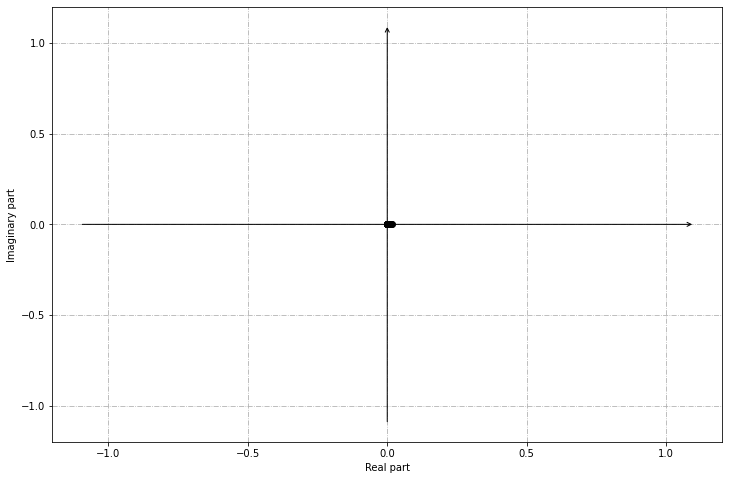

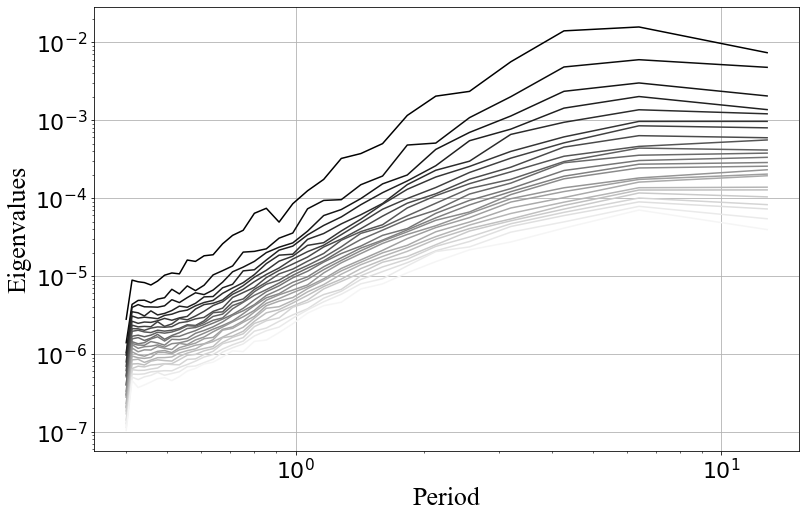

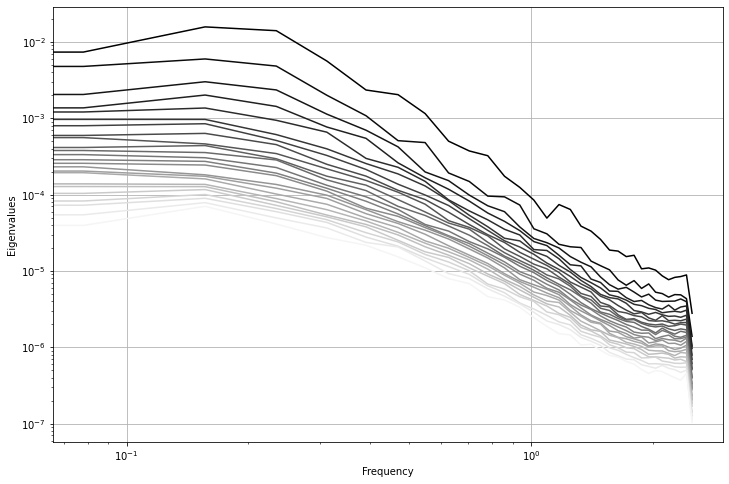

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


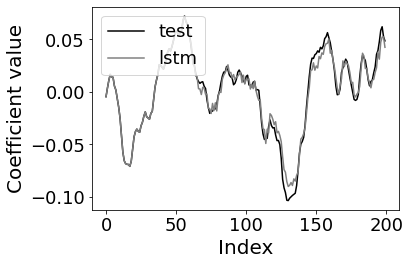

/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


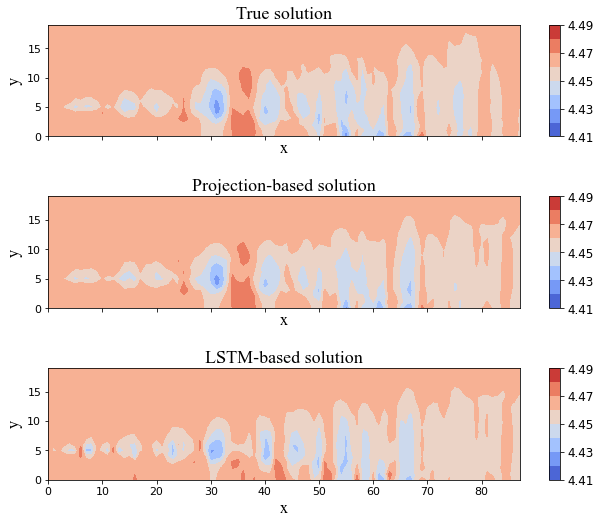

In [13]:
spod.printErrors(field_test=X_test, field_proj=proj_rec, field_emul=emulation_rec, n_snaps = 100, n_offset = 100)

#
spod.plot_eigs()
spod.plot_eigs_vs_period()
spod.plot_eigs_vs_frequency()

#routines for visualization
spod.plot_compareTimeSeries(
 	  serie1= coeffs_test['coeffs'][0,:],
 	  serie2= coeffs_emul[0,:],
 	  label1='test',
 	  label2='lstm',
 	  legendLocation = 'upper left',
 	  filename=None)

spod.generate_2D_subplot(
	title1='True solution', 
	title2='Projection-based solution', 
	title3='LSTM-based solution',
	var1=X_test[100,:,:], 
	var2=proj_rec[100,:,:,0], 
	var3=emulation_rec[100,:,:,0], 
	N_round=2, path='CWD', filename=None
)

